In [1]:
from datetime import date, datetime, time, timedelta
import pysrt
from textblob import TextBlob
import matplotlib 
from matplotlib import style
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
sns.set()
%matplotlib inline
matplotlib.rcParams['figure.figsize']=(16.0,9.0)
style.use('fivethirtyeight')
from decimal import *
import csv
import pandas as pd
import numpy as np
import os
import nltk

The Directories: Subtitles and Scene Segementation

In [2]:
scenes_dir='/people/berhe/Bureau/clean/TLP_thesis/Scenes/'
subtitle_dir='/people/berhe/Bureau/clean/TLP_thesis/subtitles/'
#scenes_dir='/home/berhe/Desktop/LIMSI/TLP_thesis/Scenes/'
#subtitle_dir='/home/berhe/Desktop/LIMSI/TLP_thesis/subtitles/'

In [3]:
subtitleFiles=[]
for fl in os.listdir(subtitle_dir):
    if '.en.srt' in fl:
       subtitleFiles.append(fl)

scenesegementedFiles=[]
for fl in os.listdir(scenes_dir):
    if 'Episode' in fl:
       scenesegementedFiles.append(fl)

In [4]:
subtitleFiles.sort()
scenesegementedFiles.sort()

In [5]:
def to_min_sec(st_ms,end_ms):
    Ssec=st_ms/1000
    Esec=end_ms/1000
    sm,ss=divmod(Ssec,60)
    em,es=divmod(Esec,60)
    return sm,ss,em,es

In [6]:
import re
def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", "", string)
    string = re.sub(r"\'s", "\'s", string)
    string = re.sub(r"\'ve", "\'ve", string)
    string = re.sub(r"n\'t", "n\'t", string)
    string = re.sub(r"\'re", "\'re", string)
    string = re.sub(r"\'d", "\'d", string)
    string = re.sub(r"\'ll", "\'ll", string)
    string = re.sub(r",", ",", string)
    string = re.sub(r"!", "!", string)
    string = re.sub("([\(\[]).*?([\)\]])", "", string)
    #string = re.sub(r")", r"", string)
    #string = re.sub(r"\?", " \? ", string)
    #string = re.sub(r"\s{2,}", " ", string)
    return string.strip()#.lower()

In [7]:
def scene_extraction(fileName):
    fileName=open(fileName,'r')
    text=fileName.readlines()
    start_scene=[]
    end_scene=[]
    story_id=[]
    for text_line in text:
        if not text_line in ['\n', '\r\n']:
            splitte_lines=text_line.split()
            try:
                start_scene.append(splitte_lines[0])
                end_scene.append(splitte_lines[1])
                story_id.append(splitte_lines[2])
            except IndexError:
                story_id.append('NA')
        else:
            continue
    return start_scene,end_scene,story_id

In [8]:
x,y,z=scene_extraction(scenes_dir+scenesegementedFiles[0])

In [9]:
len(x)

35

In [10]:
def sceneTexts(scenesegementedFiles,subtitleFiles):
    scenesegementedFiles.sort()
    subtitleFiles.sort()
    part_st=""
    scene_texts=[]
    scene_lbls=[]
    for j in range(len(scenesegementedFiles)):
        start,end,story_id=scene_extraction(scenes_dir+scenesegementedFiles[j])
        subs=pysrt.open(subtitle_dir+subtitleFiles[j],encoding='iso-8859-1')
        start=[float(i) for i in start]
        end=[float(i) for i in end]
        for i in range(len(start)):
            m,s,em,es=to_min_sec(start[i],end[i])
            part_st=subs.slice(starts_after={'minutes': m, 'seconds':s}, ends_before={'minutes': em, 'seconds': es}).text.encode('utf-8')
            scene_texts.append(part_st)
            scene_lbls.append(story_id[i])
            #if (story_id[i]==story_id[i+1]):
             #  part_st=part_st + subs.slice(starts_after={'minutes': m, 'seconds':s}, ends_before={'minutes': em, 'seconds': es}).text.encode('utf-8')
            #else:
             #   part_st=part_st + subs.slice(starts_after={'minutes': m, 'seconds':s}, ends_before={'minutes': em, 'seconds': es}).text.encode('utf-8')
              #  text_file.write(part_st)
               # text_file.write("\n------------------------------------------------------------------------\n")
                #part_st=""
    return scene_texts,scene_lbls

In [11]:
sc_txt,sc_lbl=sceneTexts(scenesegementedFiles=scenesegementedFiles,subtitleFiles=subtitleFiles)

In [12]:
len(sc_txt),len(sc_lbl)

(274, 274)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [14]:
tra_data,test_data,tra_lbl,test_lbl=train_test_split(sc_txt,sc_lbl,test_size=0.20)

In [15]:
len(tra_data),len(test_data),len(tra_lbl),len(test_lbl)

(219, 55, 219, 55)

In [16]:
from sklearn.metrics import accuracy_score
import numpy as np

def purity_score(y_true, y_pred):
    # matrix which will hold the majority-voted labels
    y_labeled_voted = np.zeros(y_true.shape)
    labels = np.unique(y_true)
    # We set the number of bins to be n_classes+2 so that 
    # we count the actual occurence of classes between two consecutive bin
    # the bigger being excluded [bin_i, bin_i+1[
    bins = np.concatenate((labels, [np.max(labels)+1]), axis=0)

    for cluster in np.unique(y_pred):
        hist, _ = np.histogram(y_true[y_pred==cluster], bins=bins)
        # Find the most present label in the cluster
        winner = np.argmax(hist)
        y_labeled_voted[y_pred==cluster] = winner

    return accuracy_score(y_true, y_labeled_voted)

TF-IDF based

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
 
#documents = ["This little kitty came to play when I was eating at a restaurant.",
            # "Merley has the best squooshy kitten belly.",
            # "Google Translate app is incredible.",
            # "If you open 100 tab in google you get a smiley face.",
             #"Best cat photo I've ever taken.",
             #"Climbing ninja cat.",
             #"Impressed with google map feedback.",
             #"Key promoter extension for Google Chrome."]
documents=tra_data
 
 
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_vector = vectorizer.fit_transform(documents).todense()
 
true_k = 10
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
cluster_labels1=model.fit_predict(tfidf_vector)
 
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:  says  letter  widowed  danger  spike  fresh  lysa  cat  murdered  ifthe
Cluster 1:  speaks  dothraki  word  great  english  khaleesi  wildlings  wall  armour  admiration
Cluster 2:  lord  ll  king  don  know  man  father  men  did  want
Cluster 3:  jaime  painted  dogsl  drink  brought  love  whore  half  young  father
Cluster 4:  bastard  grace  ned  did  winter  walkers  laughter  coming  rst  dwarves
Cluster 5:  whining  growling  ls  barks  snarling  ghost  barking  shy  whines  commander
Cluster 6:  door  toys  dolls  played  myrcella  dollmaker  knock  awayl  haven  easier
Cluster 7:  braid  stop  wouldn  khaleesi  ve  woken  manure  slut  rags  jangles
Cluster 8:  goldl  gold  lots  dwarf  rich  making  don  noisel  prepared  noise
Cluster 9:  earth  titles  chairs  dirts  coughs  memory  chair  ends  wooden  ll


In [18]:
for i in range(len(tra_data)):
    #print (test_data[i])
    print("Prediction")
    Y = vectorizer.transform([tra_data[i]])
    prediction = model.predict(Y)
    print(prediction),
    print[tra_lbl[i]]

Prediction
[2] ['3']
Prediction
[2] ['0']
Prediction
[2] ['NA']
Prediction
[2] ['2']
Prediction
[2] ['0']
Prediction
[2] ['2']
Prediction
[3] ['0']
Prediction
[2] ['NA']
Prediction
[2] ['3']
Prediction
[2] ['NA']
Prediction
[7] ['2']
Prediction
[2] ['2']
Prediction
[2] ['0']
Prediction
[2] ['0']
Prediction
[2] ['0']
Prediction
[2] ['2']
Prediction
[2] ['1']
Prediction
[2] ['NA']
Prediction
[2] ['0']
Prediction
[2] ['1']
Prediction
[2] ['0']
Prediction
[2] ['0']
Prediction
[2] ['0']
Prediction
[2] ['NA']
Prediction
[2] ['0']
Prediction
[2] ['2']
Prediction
[2] ['3']
Prediction
[2] ['1']
Prediction
[2] ['4']
Prediction
[2] ['2']
Prediction
[2] ['4']
Prediction
[2] ['3']
Prediction
[2] ['NA']
Prediction
[2] ['2']
Prediction
[2] ['2']
Prediction
[2] ['4']
Prediction
[2] ['2']
Prediction
[2] ['2']
Prediction
[2] ['3']
Prediction
[2] ['NA']
Prediction
[2] ['3']
Prediction
[2] ['2']
Prediction
[2] ['1']
Prediction
[2] ['3']
Prediction
[2] ['NA']
Prediction
[2] ['2']
Prediction
[2] ['2']
Predi

In [19]:
len(cluster_labels1),len(tra_lbl)

(219, 219)

In [20]:
from sklearn.manifold import TSNE

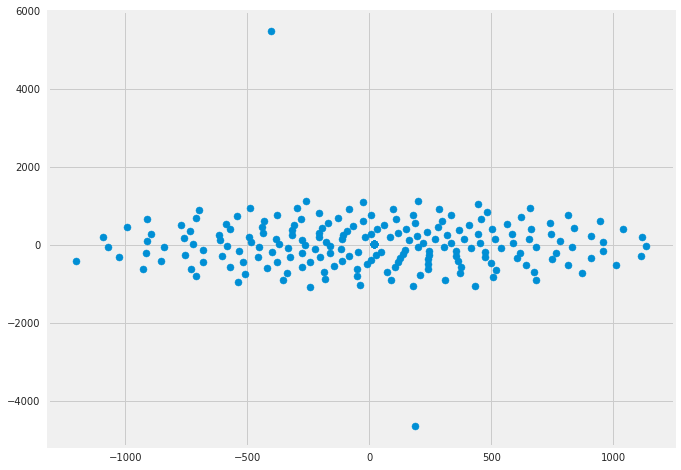

In [21]:
tsne_init = 'pca'  # could also be 'random'
tsne_perplexity = 10.0
tsne_early_exaggeration = 4.0
tsne_learning_rate = 1000
random_state = 1
model_pca = TSNE(n_components=2, random_state=random_state, init=tsne_init, perplexity=tsne_perplexity,
         early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)

transformed_vector = model_pca.fit_transform(tfidf_vector)
#print (transformed_centroids)
plt.figure(figsize=(10,8))
plt.scatter(transformed_vector[:, 0], transformed_vector[:, 1])
plt.show()

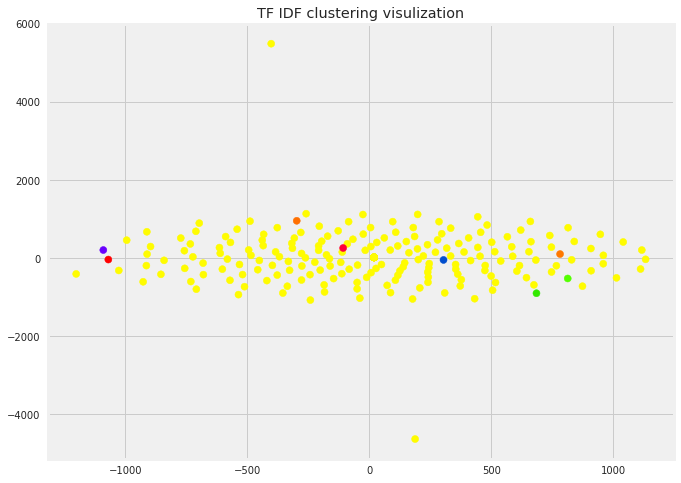

In [22]:
plt.figure(figsize=(10,8))
plt.title('TF IDF clustering visulization')
plt.scatter(transformed_vector[:,0],transformed_vector[:,1],c=cluster_labels1,cmap='prism')
plt.show()

In [23]:
print('accuracy using tf_idf vector', metrics.adjusted_rand_score(cluster_labels1, tra_lbl)) 
print('Purity is ',purity_score(cluster_labels1, tra_lbl))
print('Normalize mutual information: ',metrics.normalized_mutual_info_score(cluster_labels1, tra_lbl))

('accuracy using tf_idf vector', -0.004651737037381095)
('Purity is ', 0.0045662100456621)
('Normalize mutual information: ', 0.09526863879297677)


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

In [25]:
def plot_clusters(data, algorithm, args, kwds):
    #start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    #end_time = time.time()
    #acc=metrics.adjusted_rand_score(labels, tra_lbl)
    palette = sns.color_palette('bright', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.figure(figsize=(10,8))
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    #plt.suptitle('accuracy is {}'.format(str(acc)))
    #plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    return labels

In [26]:
def clustering_fun(data, algorithm, args, kwds):
    labels = algorithm(*args, **kwds).fit_predict(data)
    return labels

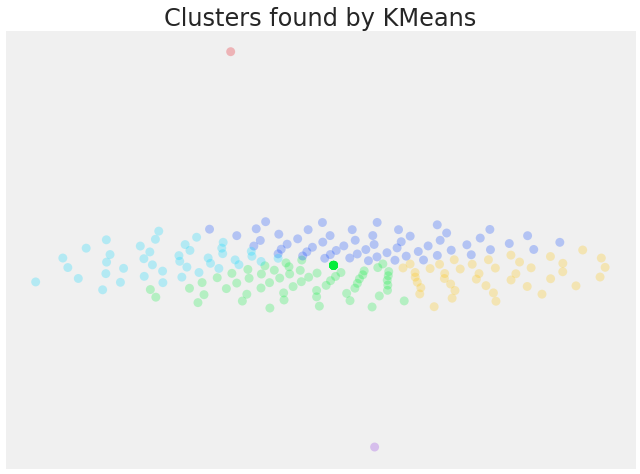

In [27]:
tf_idf_clust=plot_clusters(transformed_vector, cluster.KMeans, (), {'n_clusters':6})

In [28]:
print('accuracy using tf_idf vector', metrics.adjusted_rand_score(tf_idf_clust, tra_lbl)) 
print('Purity is ',purity_score(tf_idf_clust, tra_lbl))
print('Normalize mutual information: ',metrics.normalized_mutual_info_score(tf_idf_clust, tra_lbl))

('accuracy using tf_idf vector', 0.016811003340357976)
('Purity is ', 0.2557077625570776)
('Normalize mutual information: ', 0.06764884786158505)


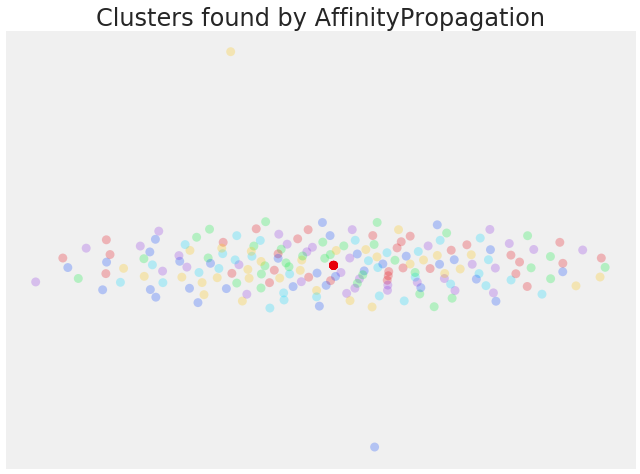

In [29]:
tf_idf_clust1=plot_clusters(transformed_vector, cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95})

In [30]:
print('accuracy using tf_idf vector', metrics.adjusted_rand_score(tf_idf_clust1, tra_lbl)) 
print('Purity is ',purity_score(tf_idf_clust1, tra_lbl))
print('Normalize mutual information: ',metrics.normalized_mutual_info_score(tf_idf_clust1, tra_lbl))

('accuracy using tf_idf vector', 0.04932151378823428)
('Purity is ', 0.0045662100456621)
('Normalize mutual information: ', 0.5502697238788496)


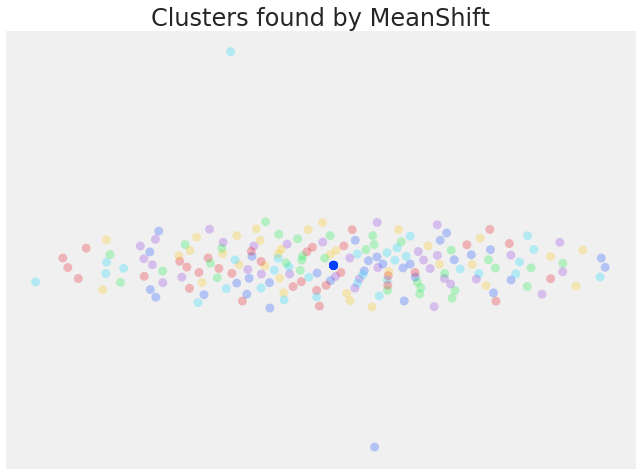

In [31]:
tf_idf_clust2=plot_clusters(transformed_vector,cluster.MeanShift, (0.175,), {'cluster_all':False})

In [32]:
print('accuracy using tf_idf vector', metrics.adjusted_rand_score(tf_idf_clust2, tra_lbl)) 
print('Purity is ',purity_score(tf_idf_clust2, tra_lbl))
print('Normalize mutual information: ',metrics.normalized_mutual_info_score(tf_idf_clust2, tra_lbl))

('accuracy using tf_idf vector', 0.049408766503944754)
('Purity is ', 0.1050228310502283)
('Normalize mutual information: ', 0.5520922411168186)


In [33]:
cls_list=list(cluster_labels1)

In [34]:
cls_lbl=set(cls_list)
sum=0
for j in cls_lbl:
    print(j, cls_list.count(j))
    sum=sum+cls_list.count(j)
print ('the sum is', sum)

(0, 1)
(1, 1)
(2, 210)
(3, 1)
(4, 1)
(5, 1)
(6, 1)
(7, 1)
(8, 1)
(9, 1)
('the sum is', 219)


In [35]:
trlbl=set(tra_lbl)
sum=0
for i in trlbl:
    print(i,tra_lbl.count(i))
    sum=sum+tra_lbl.count(i)
print ('the sum is', sum)

('NA', 30)
('1', 32)
('0', 62)
('3', 34)
('2', 52)
('5', 1)
('4', 8)
('the sum is', 219)


In [36]:
for i in range(10):
    print(test_data[i])
    print('--------------------------'),
    print(test_lbl[i])

I stole her robe.
She was forced to return to the castle
naked and in tears.
If I close my eyes,
I n still see her tits bouncing.
(GBSPS)
When I was 10,
l stuffed my uncle's boots with goatshit.
When confronted with my crime,
I blamed a squire.
Poor boy was ï¬ogged and...
l ped justice.
When I was 12 l milked my eel
into a pot of turtle stew.
- (GBSPS)
- l ï¬ogged the one-eyed snake.
l skinned my sausage.
I made the bald man cry
into the turtle stew,
which I do believe my sister ate.
At least I hope she did.
I once brought a jacloass
and a honeycomb into a brothel...
Silencel
What happened next?
What do you think you're doing?
Confessing my crimes.
Lord Tyrion, you are accused of hiring a man
to slay my son Bran in his bed,
and of conspiring to murder
my sister's husband -
Lord Jon Arryn, the Hand of the King.
Oh, I'm very sorry.
I don't know anything about all that.
You've had your little joke.
I trust you enjoyed it.
Mord, take him back to the dungeon.
But this time ï¬nd a smaller

In [37]:
Y = vectorizer.transform(["They're savages. One lot steals a goat from another lot, before you know it they're ripping each other to pieces"])
prediction = model.predict(Y)
print(prediction)

[2]


In [38]:
Y = vectorizer.transform(["Lannisters don't act like fools now help me keep the damn thing."])
prediction = model.predict(Y)
print(prediction)

[2]


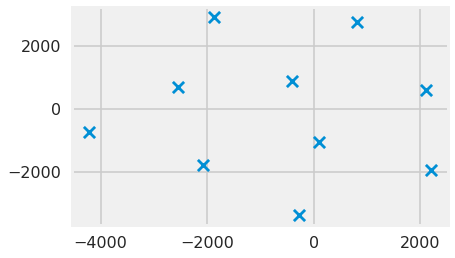

In [39]:
centroids = model.cluster_centers_
tsne_init = 'pca'  # could also be 'random'
tsne_perplexity = 10.0
tsne_early_exaggeration = 4.0
tsne_learning_rate = 1000
random_state = 1
model1 = TSNE(n_components=2, random_state=random_state, init=tsne_init, perplexity=tsne_perplexity,
         early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)

transformed_centroids = model1.fit_transform(centroids)
#print (transformed_centroids)
plt.scatter(transformed_centroids[:, 0], transformed_centroids[:, 1], marker='x')
plt.show()

Vector Count 

In [40]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import ward, dendrogram

In [41]:
vectorizer = CountVectorizer(input='content')
dtm = vectorizer.fit_transform(tra_data)
vocab = vectorizer.get_feature_names()

In [42]:
dtm.shape

(219, 3721)

In [43]:
dtm=dtm.toarray()
vocab=np.array(vocab)

In [44]:
snow_idx = list(vocab).index('snow')
snow_idx

2950

In [45]:
n, _ = dtm.shape
dist_eclud = np.zeros((n, n))

In [46]:
dist_eclud = euclidean_distances(dtm)

In [47]:
for i in range(n):
    for j in range(n):
        x, y = dtm[i, :], dtm[j, :]
        dist_eclud[i, j] = np.sqrt(np.sum((x - y)**2))

In [48]:
np.round(dist_eclud, 1)

array([[ 0. , 23.9, 23.8, ..., 23.8, 20.5, 23.5],
       [23.9,  0. ,  3.7, ...,  3.7, 15.7,  6.7],
       [23.8,  3.7,  0. , ...,  0. , 15.8,  6.4],
       ...,
       [23.8,  3.7,  0. , ...,  0. , 15.8,  6.4],
       [20.5, 15.7, 15.8, ..., 15.8,  0. , 15. ],
       [23.5,  6.7,  6.4, ...,  6.4, 15. ,  0. ]])

In [49]:
import os
import matplotlib.pyplot as plt
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos=mds.fit_transform(dist_eclud)

In [50]:
xs,ys=pos[:, 0],pos[:,1]

In [51]:
names=['story 1','story 2','story 3','story 4','story 5','story 6']

<function matplotlib.pyplot.show>

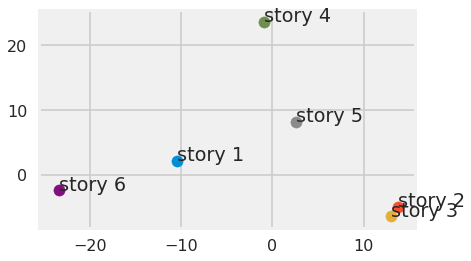

In [52]:
for x, y, name in zip(xs, ys, names):
    plt.scatter(x, y)
    plt.text(x, y, name)
    
plt.show

In [53]:
cos_sim = 1 - cosine_similarity(dtm)

In [54]:
cos_sim.shape

(219, 219)

In [55]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos=mds.fit_transform(cos_sim)
xs,ys=pos[:, 0],pos[:,1]

<function matplotlib.pyplot.show>

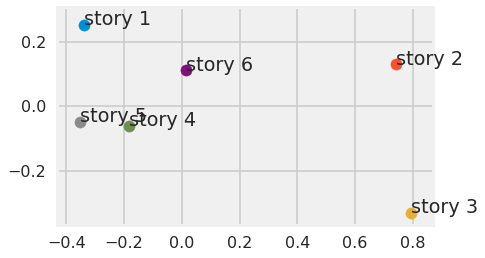

In [56]:
for x, y, name in zip(xs, ys, names):
    plt.scatter(x, y)
    plt.text(x, y, name)
    
plt.show

In [57]:
mds = MDS(n_components=3, dissimilarity="precomputed", random_state=1)
pos1=mds.fit_transform(cos_sim)

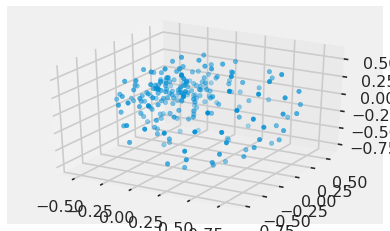

In [58]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos1[:, 0], pos1[:, 1], pos1[:, 2])

In [59]:
from scipy.cluster.hierarchy import ward, dendrogram,complete
link_matr=ward(dtm)

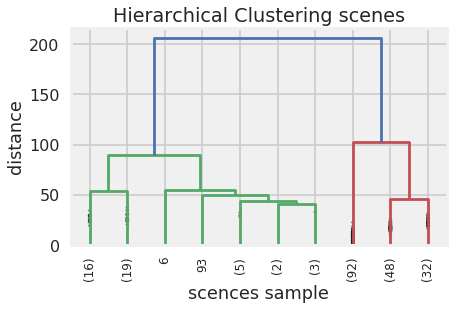

In [60]:
plt.title('Hierarchical Clustering scenes')
plt.xlabel('scences sample')
plt.ylabel('distance')
dendrogram(link_matr,truncate_mode='lastp',leaf_rotation=90,leaf_font_size=12,p=10,show_contracted=True)
plt.show()

In [61]:
from scipy.cluster.hierarchy import fcluster
clusters=fcluster(link_matr,5,depth=20)
clusters

array([3, 2, 2, 1, 3, 1, 1, 2, 3, 2, 3, 2, 2, 3, 2, 2, 3, 2, 3, 2, 2, 3,
       1, 2, 3, 2, 3, 2, 2, 3, 2, 3, 2, 3, 1, 1, 1, 1, 3, 2, 3, 2, 3, 3,
       2, 3, 1, 3, 1, 2, 2, 1, 2, 2, 1, 3, 3, 2, 2, 1, 2, 2, 3, 3, 2, 3,
       2, 3, 2, 2, 3, 3, 2, 2, 1, 1, 2, 2, 2, 3, 1, 2, 3, 2, 3, 1, 3, 2,
       2, 3, 2, 3, 3, 1, 1, 2, 2, 1, 3, 2, 2, 2, 2, 3, 3, 2, 3, 3, 3, 2,
       2, 3, 3, 2, 2, 2, 3, 2, 2, 1, 2, 2, 3, 3, 2, 3, 2, 3, 3, 2, 1, 3,
       3, 3, 1, 3, 3, 1, 2, 2, 2, 2, 1, 3, 3, 2, 1, 2, 2, 2, 1, 3, 3, 3,
       2, 2, 2, 2, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 2, 3, 2,
       2, 2, 2, 3, 2, 3, 1, 2, 1, 2, 2, 1, 3, 1, 1, 1, 3, 1, 2, 1, 2, 3,
       1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 1, 2, 2, 2, 3, 1, 2, 2, 3, 2],
      dtype=int32)

In [62]:
len(clusters),len(tra_lbl),len(link_matr),len(cos_sim)

(219, 219, 218, 219)

In [63]:
print("accuracy of the cluster ",metrics.adjusted_rand_score(clusters,tra_lbl))

('accuracy of the cluster ', 0.028256618590222313)


In [64]:
print('the purrity score ',purity_score(clusters, tra_lbl))

('the purrity score ', 0.0)


In [65]:
print('Normalize mutual information: ',metrics.normalized_mutual_info_score(clusters, tra_lbl))

('Normalize mutual information: ', 0.0679776132832819)


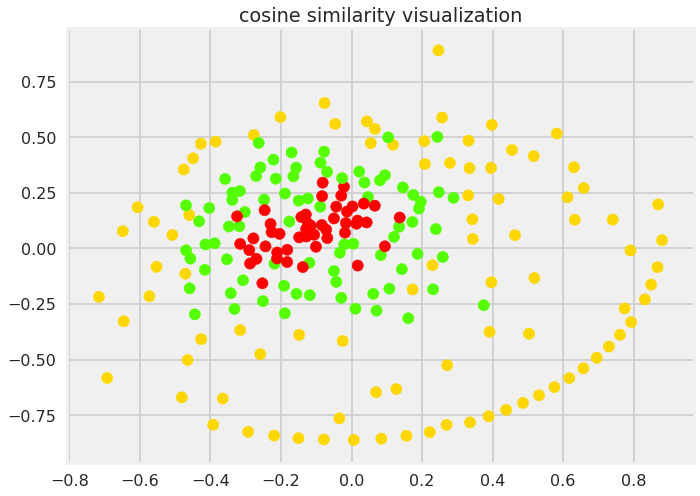

In [66]:
plt.figure(figsize=(10,8))
plt.title('cosine similarity visualization')
plt.scatter(pos[:,0],pos[:,1],c=clusters,cmap='prism')
plt.show()

In [67]:
cl=list(clusters)

In [68]:
for i in set(cl):
    print (i, cl.count(i))

(1, 47)
(2, 92)
(3, 80)


In [69]:
clusters

array([3, 2, 2, 1, 3, 1, 1, 2, 3, 2, 3, 2, 2, 3, 2, 2, 3, 2, 3, 2, 2, 3,
       1, 2, 3, 2, 3, 2, 2, 3, 2, 3, 2, 3, 1, 1, 1, 1, 3, 2, 3, 2, 3, 3,
       2, 3, 1, 3, 1, 2, 2, 1, 2, 2, 1, 3, 3, 2, 2, 1, 2, 2, 3, 3, 2, 3,
       2, 3, 2, 2, 3, 3, 2, 2, 1, 1, 2, 2, 2, 3, 1, 2, 3, 2, 3, 1, 3, 2,
       2, 3, 2, 3, 3, 1, 1, 2, 2, 1, 3, 2, 2, 2, 2, 3, 3, 2, 3, 3, 3, 2,
       2, 3, 3, 2, 2, 2, 3, 2, 2, 1, 2, 2, 3, 3, 2, 3, 2, 3, 3, 2, 1, 3,
       3, 3, 1, 3, 3, 1, 2, 2, 2, 2, 1, 3, 3, 2, 1, 2, 2, 2, 1, 3, 3, 3,
       2, 2, 2, 2, 3, 1, 1, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1, 3, 3, 2, 3, 2,
       2, 2, 2, 3, 2, 3, 1, 2, 1, 2, 2, 1, 3, 1, 1, 1, 3, 1, 2, 1, 2, 3,
       1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 1, 2, 2, 2, 3, 1, 2, 2, 3, 2],
      dtype=int32)

In [70]:
link_matr2=complete(dist_eclud)

/people/berhe/.virtualenvs/Proj_env/local/lib/python2.7/site-packages/scipy/cluster/hierarchy.py:298: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='complete', metric='euclidean')


In [71]:
clusters_ecl=fcluster(link_matr2,5,depth=10)
clusters_ecl

array([5, 2, 2, 6, 4, 6, 1, 2, 5, 2, 6, 3, 2, 5, 3, 3, 6, 2, 5, 3, 3, 4,
       7, 3, 4, 2, 3, 3, 2, 6, 3, 5, 2, 5, 1, 6, 6, 6, 5, 2, 5, 3, 3, 6,
       2, 5, 6, 4, 6, 3, 3, 6, 3, 3, 6, 5, 3, 2, 3, 6, 2, 2, 4, 4, 2, 5,
       3, 5, 2, 3, 4, 3, 2, 3, 6, 6, 2, 2, 2, 4, 7, 2, 4, 4, 3, 7, 4, 3,
       3, 4, 2, 4, 6, 1, 6, 3, 3, 5, 4, 3, 2, 2, 3, 5, 3, 2, 5, 5, 4, 3,
       4, 5, 5, 2, 2, 3, 4, 2, 3, 6, 2, 3, 3, 4, 2, 5, 3, 6, 4, 2, 7, 4,
       3, 5, 7, 5, 6, 6, 2, 2, 3, 2, 7, 5, 5, 2, 6, 3, 2, 2, 7, 4, 4, 5,
       3, 2, 3, 3, 5, 7, 6, 3, 6, 4, 4, 6, 6, 6, 4, 5, 1, 4, 5, 2, 6, 3,
       3, 2, 2, 5, 2, 5, 7, 2, 6, 3, 2, 6, 4, 6, 5, 6, 5, 6, 2, 6, 3, 5,
       6, 6, 6, 3, 2, 5, 5, 4, 5, 4, 4, 7, 3, 3, 2, 4, 6, 3, 2, 4, 3],
      dtype=int32)

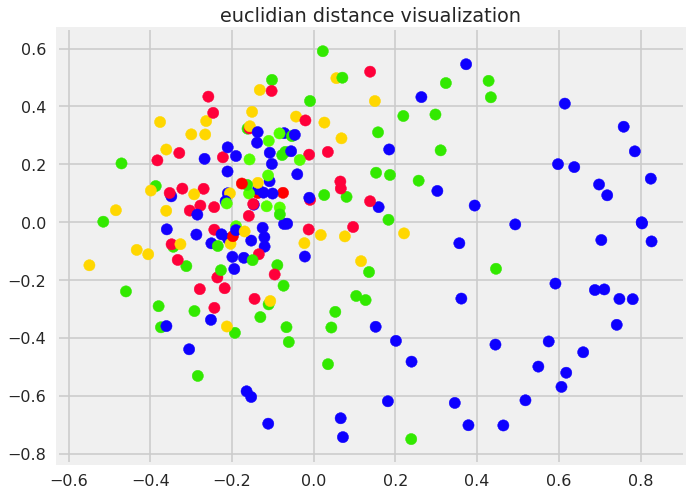

In [72]:
plt.figure(figsize=(10,8))
plt.title('euclidian distance visualization')
plt.scatter(pos1[:,0],pos1[:,1],c=clusters_ecl,cmap='prism')
plt.show()

In [73]:

len(clusters_ecl),len(tra_lbl),len(link_matr)   

(219, 219, 218)

In [74]:
print('accuracy', metrics.adjusted_rand_score(clusters_ecl, tra_lbl)) 
print('the purity score is ', purity_score(clusters_ecl,tra_lbl))
print('Normalize Mutual Information', metrics.normalized_mutual_info_score(clusters_ecl,tra_lbl))

('accuracy', 0.043835048468161865)
('the purity score is ', 0.0)
('Normalize Mutual Information', 0.10107431419433907)


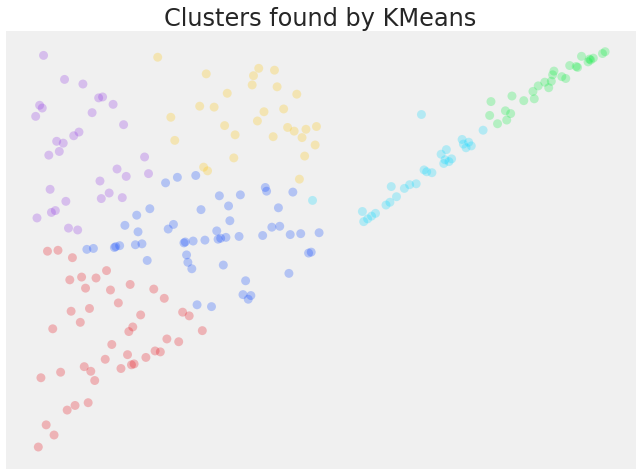

In [75]:
cos_cluster=plot_clusters(link_matr, cluster.KMeans, (), {'n_clusters':6})

In [76]:
#print("accuracy of the cluster ",metrics.adjusted_rand_score(cos_cluster,tra_lbl))
print('the purity score is ', purity_score(cos_cluster,tra_lbl))

('the purity score is ', 0.24770642201834864)


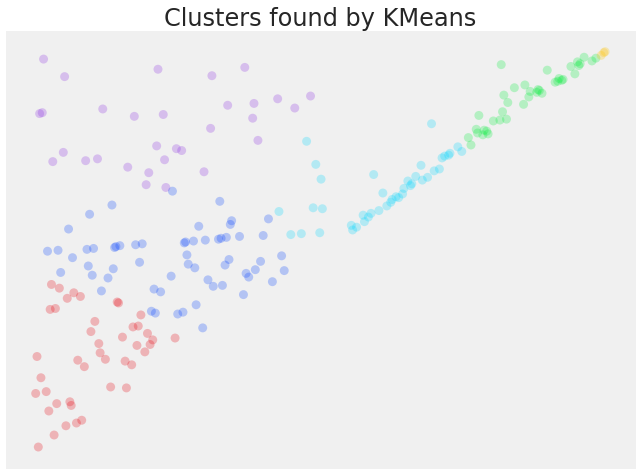

In [77]:
ecl_cluster=plot_clusters(link_matr2, cluster.KMeans, (), {'n_clusters':6})

In [78]:
print('the purity score is ', purity_score(ecl_cluster,tra_lbl))

('the purity score is ', 0.27522935779816515)


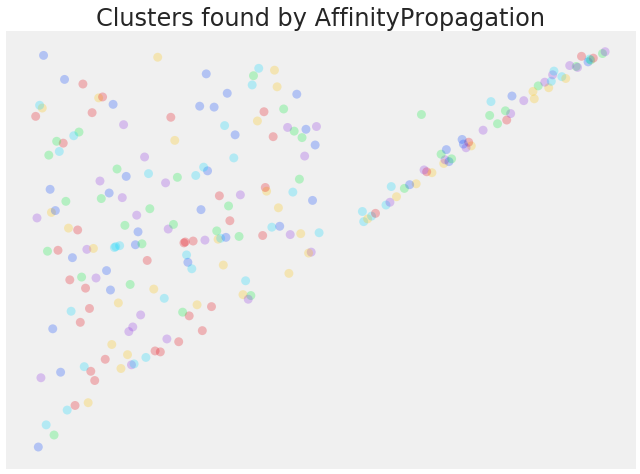

In [79]:
cos_aff_clu=plot_clusters(link_matr, cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95})

In [80]:
print('the purity score is ', purity_score(cos_aff_clu,tra_lbl))

('the purity score is ', 0.0045871559633027525)


In [81]:
len(cos_aff_clu),len(tra_lbl)

(218, 219)

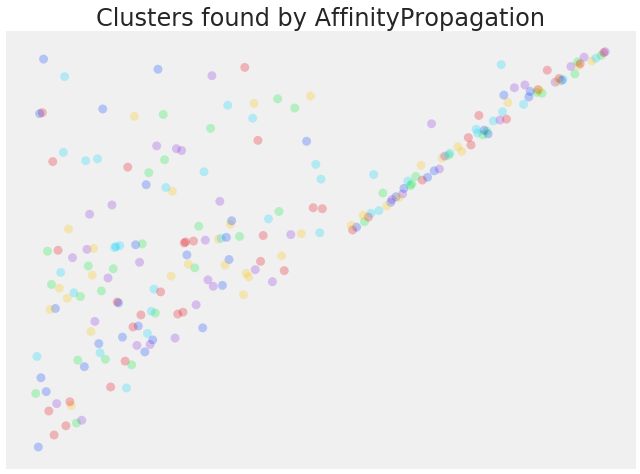

In [82]:
ecl_aff_clu=plot_clusters(link_matr2, cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95})

In [83]:
print('the purity score is ', purity_score(ecl_aff_clu,tra_lbl))

('the purity score is ', 0.0045871559633027525)


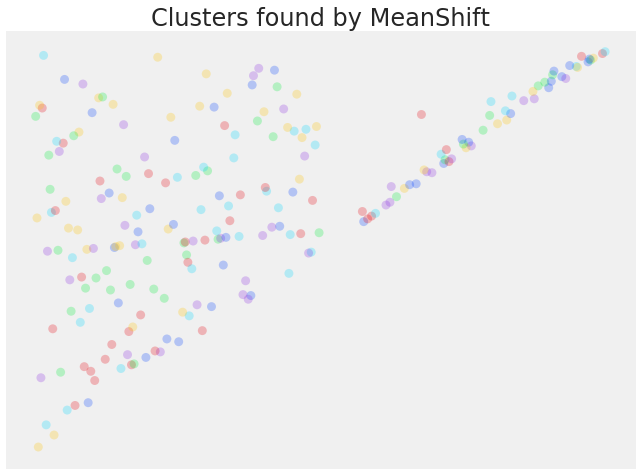

In [84]:
cos_mn_shift=plot_clusters(link_matr, cluster.MeanShift, (0.175,), {'cluster_all':False})

In [85]:
print('the purity score is ', purity_score(cos_mn_shift,tra_lbl))

('the purity score is ', 0.0045871559633027525)


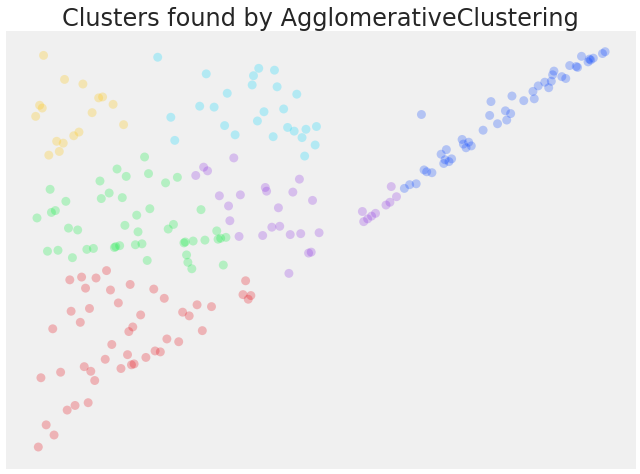

In [86]:
cos_agg_cl=plot_clusters(link_matr, cluster.AgglomerativeClustering, (), {'n_clusters':6, 'linkage':'ward'})

In [87]:
print('the purity score is ', purity_score(cos_agg_cl,tra_lbl))

('the purity score is ', 0.21559633027522937)


In [88]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot

/people/berhe/.virtualenvs/Proj_env/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


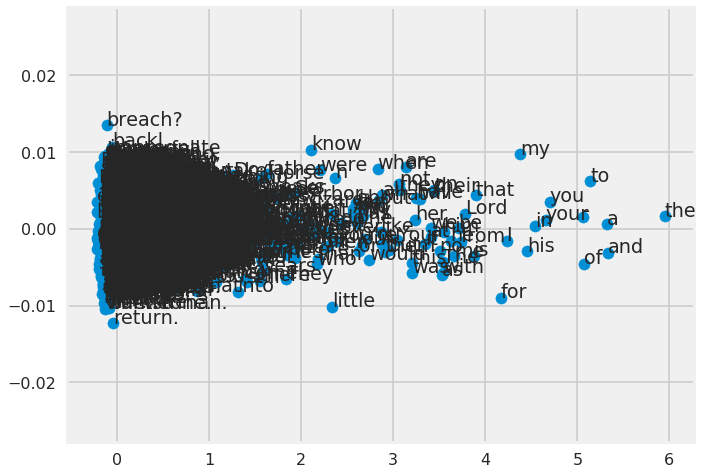

In [89]:
text=""
for i in sc_txt:
    text=text+" "+i
txtblb=TextBlob(text.decode('utf-8'))
sentences=[]
for sent in txtblb.sentences:
    sentences.append(sent.split())
w2vModel=Word2Vec(sentences,min_count=1)
X=w2vModel[w2vModel.wv.vocab]
pca=PCA(n_components=2)
result=pca.fit_transform(X)
words=list(w2vModel.wv.vocab)
pyplot.figure(figsize=(10,8))
pyplot.scatter(result[:, 0],result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i,0], result[i,1]))
pyplot.show()

In [90]:
print(sentences[2])

[u"They're", u'savages.']


In [91]:
X=w2vModel[w2vModel.wv.vocab]
modelEmbd = KMeans(n_clusters=6, init='k-means++', max_iter=100, n_init=1)
#modelEmbd.fit(X)
cluster_labels =modelEmbd.fit_predict(X)
print("Top terms per cluster:")
order_centroids = modelEmbd.cluster_centers_.argsort()[:, ::-1]
terms = list(w2vModel.wv.vocab)
for i in range(6):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:  flicking  guardsmen  hurt  Jorah?  horde.  "Counting  reports  Tonight,  (Bird  pieces.
Cluster 1:  flicking  guardsmen  hurt  Jorah?  horde.  "Counting  reports  Tonight,  (Bird  pieces.
Cluster 2:  flicking  guardsmen  hurt  Jorah?  horde.  "Counting  reports  Tonight,  (Bird  pieces.
Cluster 3:  flicking  guardsmen  hurt  Jorah?  horde.  "Counting  reports  Tonight,  (Bird  pieces.
Cluster 4:  flicking  guardsmen  hurt  Jorah?  horde.  "Counting  reports  Tonight,  (Bird  pieces.
Cluster 5:  flicking  guardsmen  hurt  Jorah?  horde.  "Counting  reports  Tonight,  (Bird  pieces.


/people/berhe/.virtualenvs/Proj_env/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [92]:
X.shape

(7652, 100)

In [93]:
print(len(list(w2vModel.wv.vocab)))

7652


In [94]:
from nltk.cluster import KMeansClusterer
X=w2vModel[w2vModel.wv.vocab]
kclustere = KMeansClusterer(5, distance=nltk.cluster.util.cosine_distance,repeats=25)
assigned_clusters=kclustere.cluster(X,assign_clusters=True)
print(assigned_clusters)

/people/berhe/.virtualenvs/Proj_env/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


[1, 4, 1, 1, 1, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 3, 1, 2, 0, 1, 4, 1, 3, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 2, 4, 4, 1, 1, 4, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 1, 1, 0, 1, 3, 1, 1, 4, 1, 1, 1, 1, 1, 2, 0, 4, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 4, 0, 1, 1, 0, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 4, 1, 1, 1, 1, 1, 1, 2, 1, 1, 4, 3, 3, 0, 1, 1, 1, 1, 1, 4, 2, 1, 1, 1, 0, 4, 1, 1, 1, 1, 1, 4, 1, 0, 4, 1, 1, 1, 1, 1, 4, 1, 4, 3, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 0, 1, 1, 1, 1, 4, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 4, 1, 1, 1, 1, 4, 1, 1, 3, 1, 3, 3, 1, 1, 2, 1, 1, 1, 4, 1, 1, 1, 4, 4, 1, 4, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 4, 1, 1, 4, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 4, 1, 1, 

In [95]:
words=list(w2vModel.wv.vocab)
for i, word in enumerate(words):
    print (word + "." +str(assigned_clusters[i]))

"Counting.1
Tonight,.4
Greyjoy.1
(Jeering,.1
(Jeering).1
four.1
Does.1
Untie.4
spiders.1
funl.4
screaming).1
Until.1
marching.1
brothers-in-arms..1
lord.1
flicking.1
innocence..4
Famed.1
horde's.1
advice,.1
(Dogs.1
yellow.1
(Bird.1
horde..3
So...you're.1
disturb.2
Less.0
wooden.1
brutish.4
woods.1
disadvanhge..3
guardsmen.1
Targaryen..1
Targaryen,.1
her..1
her,.1
ate..1
27,.4
Targaryen?.1
elegant.1
second.1
her?.1
valiant.1
sailed.1
strong,".1
understood?.2
thunder.4
nature..4
report..1
hoofbeats).1
hero.4
dirts..0
herl.1
reasons..1
here.1
titles,.1
titles..1
ironies..0
hers.1
Targaryens.1
climbed.1
reports.2
pieces..1
better-looking..1
bellowing).1
Stand.1
golden.1
Iling).1
stewards..1
Three.1
summons.1
brought.1
anywhere..1
stern.1
"The.1
opponents.1
Jorah,.1
Jorah..1
spoke.1
Jorah?.1
untie.4
ï¬shermen.4
apparently..4
until.1
"kingslayer".1
-Sawmewithyourowneyes?.0
hereby.1
show..3
hurt.1
Inform.1
opponent?.4
ï¬aps.1
hold.1
locked.1
(Metal.1
pursue.1
boar....2
blade.0
Boys,.4
(Scra

upon..1
hospitality..1
loves.1
visited.4
coronation.4
ï¬eld..2
ï¬eld,.1
sadly..1
comfortable.4
tide.1
have.1
throat.1
curved.1
savage..4
savage,.4
patience..4
patience,.1
concerns.1
boy,".1
patience?.3
Glad.4
savages.1
unless.1
coronation..1
gods..4
business..4
where's.1
Without.1
eight.1
clothes..1
savaged.3
wake..1
business?.1
favourites.0
Yet....4
Oi..1
asyouusedtobe?.1
gather.1
Some.1
saying?.4
..did.2
pompous,.0
(Courtiers.1
coppers..4
saying..1
saying,.1
conï¬rm.1
(Groans).1
reputation..1
traitor.1
beheaded....4
Home..3
inspiring.1
grabbed.1
madman.1
controls.1
appointments..1
halfwit.0
battlements,.1
Kingsroad..1
beat.1
bear.1
do....1
Throne?.1
anything..1
Needle..4
anything,.1
Throne,.1
Throne..1
Tall..4
Needle?.0
straight..1
yours?.1
Island..1
asidel.1
squalling..1
faces?.4
shitsl.1
awaits.1
Aleena?.1
master's.1
yourself....1
100-foot.1
rapers.1
shorter..4
weak.1
Justice..1
deliver.1
thanks..4
aside,.1
Islands.1
shits..2
joke.1
taking.1
(Sighs,.1
assure.3
purse..2
(Laughter

In [96]:
lblset=set(assigned_clusters)
for i in lblset:
    print (i,assigned_clusters.count(i))
    

(0, 397)
(1, 5577)
(2, 248)
(3, 353)
(4, 1077)


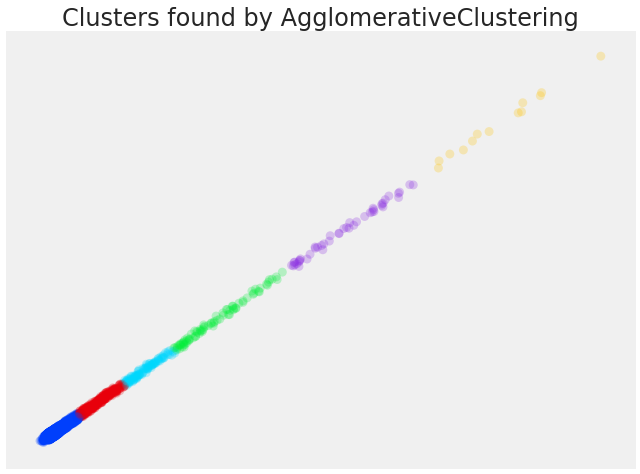

In [97]:
w2v_agg=plot_clusters(X, cluster.AgglomerativeClustering, (), {'n_clusters':6, 'linkage':'ward'})

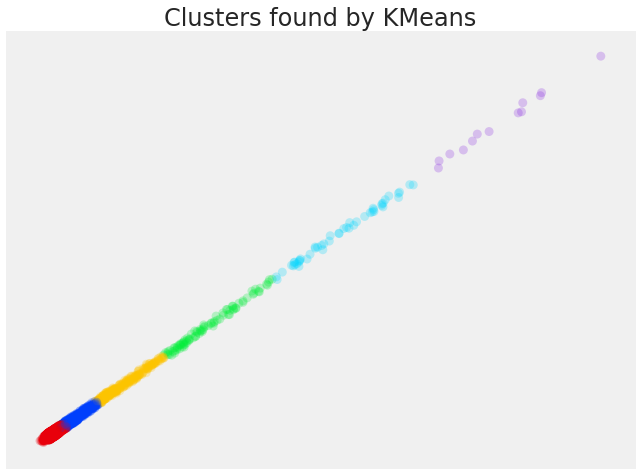

In [98]:
w2v_agg=plot_clusters(X, cluster.KMeans, (), {'n_clusters':6})

Doc2Vec: Documentto Vectors

In [99]:
from gensim.models import doc2vec
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from nltk import word_tokenize
from matplotlib import pyplot
from gensim.models.doc2vec import TaggedDocument

In [100]:
tokenizer = RegexpTokenizer(r'\w+')
stopword_set = set(stopwords.words('english'))

In [101]:
def nlp_clean(data):
   new_data = []
   for d in data:
      #new_str=d.decode('utf-8')
      #new_str = d.lower()
      dlist = tokenizer.tokenize(d)
      dlist = list(set(dlist).difference(stopword_set))
      new_data.append(dlist)
   return new_data

In [102]:
sc_txt1=[x.split() for x in sc_txt]

In [103]:
new_data=nlp_clean(sc_txt)

In [104]:
docs1=[]
for i in sc_txt:
    str_list=i.split()
    T=TaggedDocument(str_list,[i])
    docs1.append(T)

In [105]:
len(docs1)

274

In [106]:
D2V_model = doc2vec.Doc2Vec(docs1, size=100, window=1, min_count=1, workers=1)

In [107]:
doc_vect=D2V_model[D2V_model.wv.vocab]

/people/berhe/.virtualenvs/Proj_env/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [108]:
doc_vect[3]

array([ 1.78449154e-02, -4.19995980e-03, -6.28838257e-04,  5.86537551e-03,
       -7.38666672e-03, -6.89006830e-03, -9.11428127e-04, -2.11776756e-02,
       -1.00234495e-02, -6.60898956e-03,  9.88635980e-03, -1.06448634e-02,
       -1.28569454e-02,  2.09780061e-03,  8.39492679e-03,  5.58117218e-03,
        3.12485639e-03, -9.35988408e-03,  5.15849737e-04, -5.88036934e-03,
        6.23995950e-03,  5.23702547e-05,  1.89102199e-02,  7.07587833e-03,
        1.98128726e-02,  4.68127243e-03,  1.24138333e-02,  1.51427172e-03,
        1.34231267e-03, -4.04000375e-03, -8.55897926e-03,  6.35861931e-03,
       -1.18023893e-02,  1.33470248e-03,  3.30490200e-03,  6.18223520e-03,
        1.09971957e-02, -1.27341703e-03,  2.53918045e-03, -2.76272860e-03,
       -1.02615515e-02,  3.95418191e-03,  3.65068135e-03, -1.69167935e-03,
       -1.41974939e-02, -8.06404557e-03, -9.41504259e-05,  7.63202878e-03,
        1.00151822e-03,  7.88453035e-03,  1.30266054e-02,  3.62399593e-03,
        5.63576212e-03, -

In [109]:
train_vect=[]
duplicate_dict={}
used_lines=[]
for i, t in enumerate(tra_data):
    duplicate_dict[t]=True
    used_lines.append(t)
    train_vect.append(D2V_model.infer_vector(t))
print('finished doc vectors')

finished doc vectors


In [110]:
len(train_vect),len(tra_data)

(219, 219)

In [111]:
print(train_vect[10])

[ 0.6142108  -0.115418   -0.07469398  0.09835951 -0.19875039 -0.17680413
 -0.12504087 -0.6822743  -0.22531167 -0.15066057  0.40493113 -0.17855142
 -0.24256639  0.08332181  0.12595525  0.19641192  0.1161292  -0.14543878
 -0.03640757 -0.06823172  0.04738083  0.09358294  0.50121164  0.2419466
  0.50189     0.03480341  0.41982004  0.16694471 -0.01064429 -0.03598559
 -0.15569207  0.13137825 -0.27933672  0.02162924  0.20727123  0.23755777
  0.19137867 -0.1765938   0.16353993 -0.06247263 -0.23991469  0.06046227
  0.15905978 -0.00653116 -0.39440018 -0.16173328 -0.01236988  0.08485407
  0.09560113  0.28774503  0.27086332  0.04262802  0.20491369 -0.11463788
 -0.10994641 -0.05011692 -0.16592255  0.06459584 -0.00124034 -0.38127235
 -0.1622531  -0.09874276 -0.02978557 -0.15265782  0.41612303 -0.22081469
 -0.02600043 -0.12602037 -0.13816725 -0.2264281  -0.10427821 -0.08924406
 -0.89947873 -0.016618   -0.07274284  0.32839286  0.4208546   0.37492803
 -0.1592032   0.09936544 -0.04616     0.22914697  0.

In [112]:
train_vect=np.array(train_vect)

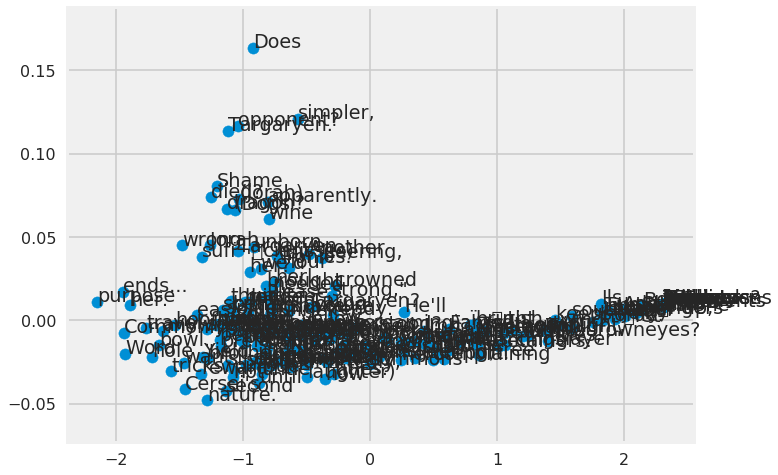

In [113]:
pca1=PCA(n_components=2)
result1=pca1.fit_transform(train_vect)
words=list(D2V_model.wv.vocab)
words=[i.decode('utf-8') for i in words]
pyplot.figure(figsize=(10,8))
pyplot.scatter(result1[:, 0],result1[:, 1])
for i, word in enumerate(words):
    try:
        pyplot.annotate(word, xy=(result1[i,0], result1[i,1]))
    except:
        break
pyplot.show()

In [114]:
len(words)

7652

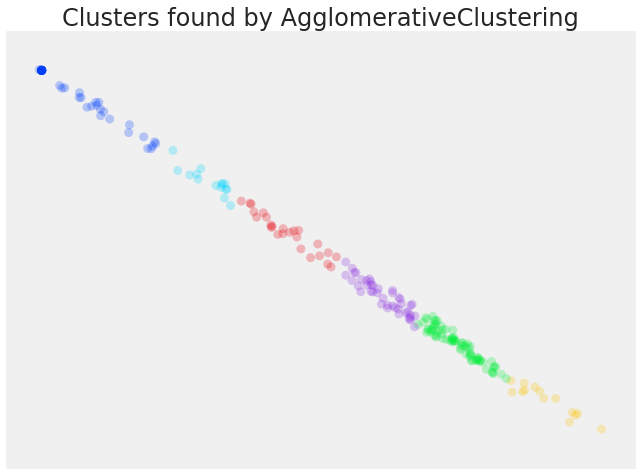

In [115]:
doc2vec_agg=plot_clusters(train_vect, cluster.AgglomerativeClustering, (), {'n_clusters':6, 'linkage':'ward'})

In [116]:
print('accuracy', metrics.adjusted_rand_score(doc2vec_agg, tra_lbl))
print('the purity score is ', purity_score(doc2vec_agg,tra_lbl))
print('Normalize Mutual Information', metrics.normalized_mutual_info_score(doc2vec_agg,tra_lbl))

('accuracy', 0.03700113245054208)
('the purity score is ', 0.2146118721461187)
('Normalize Mutual Information', 0.10185568471303796)


In [117]:
train_vect.shape

(219, 100)

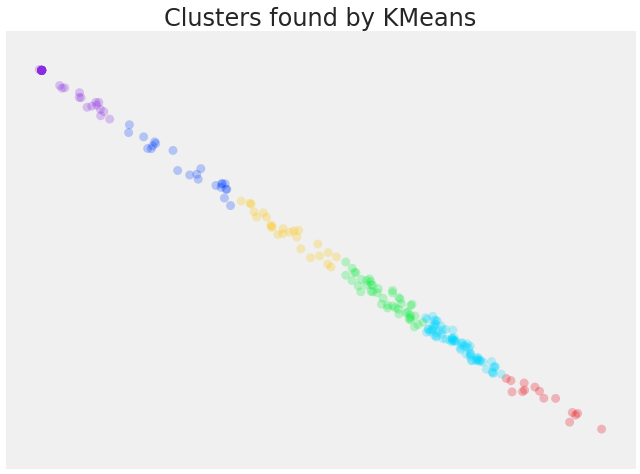

In [118]:
d2v_kmeans=plot_clusters(train_vect, cluster.KMeans, (), {'n_clusters':6})

In [119]:
print('accuracy', metrics.adjusted_rand_score(d2v_kmeans, tra_lbl)) 
print('the purity score is ', purity_score(d2v_kmeans,tra_lbl))
print('Normalize Mutual Information', metrics.normalized_mutual_info_score(d2v_kmeans,tra_lbl))

('accuracy', 0.04657260299501592)
('the purity score is ', 0.1050228310502283)
('Normalize Mutual Information', 0.11609155560832671)


In [120]:
d2v_kmeans=list(d2v_kmeans)
clusters_doc2vec=set(d2v_kmeans)
for i in clusters_doc2vec:
    print(i,d2v_kmeans.count(i))

(0, 23)
(1, 44)
(2, 15)
(3, 39)
(4, 25)
(5, 73)


In [121]:
uniq_lbl=set(tra_lbl)
for i in uniq_lbl:
    print(i,tra_lbl.count(i))

('NA', 30)
('1', 32)
('0', 62)
('3', 34)
('2', 52)
('5', 1)
('4', 8)


In [135]:
kmeans_results=pd.DataFrame(columns=('k_value','accuracy','purity','NMI'))

In [136]:
for k in range(1,20):
    d2v_kmeans=clustering_fun(train_vect, cluster.KMeans, (), {'n_clusters':k})
    acc=metrics.adjusted_rand_score(d2v_kmeans, tra_lbl)
    purity=purity_score(d2v_kmeans,tra_lbl)
    nmi=metrics.normalized_mutual_info_score(d2v_kmeans,tra_lbl)
    print(acc,purity,nmi)
    lis_k=[int(k),acc,purity,nmi]
    kmeans_results.loc[k]=lis_k

(0.0, 1.0, -1.3877787807814457e-07)
(0.044072285537693746, 0.6666666666666666, 0.07178900945817882)
(0.055925827437363594, 0.5662100456621004, 0.10069569801848897)
(0.04860004269179017, 0.2146118721461187, 0.0944170855971347)
(0.05062182504207512, 0.3424657534246575, 0.11018731569203263)
(0.04657260299501592, 0.1050228310502283, 0.11609155560832671)
(0.04968880494050223, 0.1278538812785388, 0.1105326274247701)
(0.056262380781419916, 0.091324200913242, 0.12858837034394385)
(0.051248720633286136, 0.1963470319634703, 0.1328273251263077)
(0.05202503180447851, 0.1141552511415525, 0.13425961536534176)
(0.05062432774835923, 0.1050228310502283, 0.1458657516067593)
(0.0534225224542848, 0.0502283105022831, 0.1440319441152694)
(0.05554325600307966, 0.0593607305936073, 0.15893033485487823)
(0.05274823257657189, 0.1232876712328767, 0.1514803613530358)
(0.054415793226982374, 0.091324200913242, 0.16505725447823644)
(0.06133023798246707, 0.045662100456621, 0.17391053303637066)
(0.04875842269328769, 0.

In [137]:
kmeans_results

,k_value,accuracy,purity,NMI
1,1.0,0.000000,1.000000,-1.387779e-07
2,2.0,0.044072,0.666667,7.178901e-02
3,3.0,0.055926,0.566210,1.006957e-01
4,4.0,0.048600,0.214612,9.441709e-02
5,5.0,0.050622,0.342466,1.101873e-01
6,6.0,0.046573,0.105023,1.160916e-01
7,7.0,0.049689,0.127854,1.105326e-01
8,8.0,0.056262,0.091324,1.285884e-01
9,9.0,0.051249,0.196347,1.328273e-01
10,10.0,0.052025,0.114155,1.342596e-01


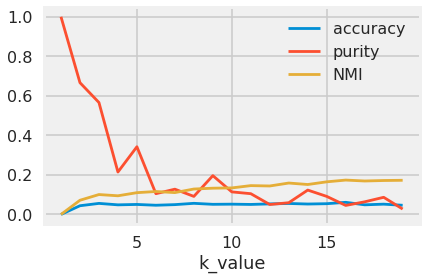

In [138]:
kmeans_results.plot(x='k_value')

In [139]:
kmeans_results.accuracy.max(),kmeans_results.purity.max()

(0.06133023798246707, 1.0)

In [127]:
agg_results=pd.DataFrame(columns=('k_value','accuracy','purity','NMI'))
for k in range(1,20):
    d2v_kmeans=clustering_fun(train_vect, cluster.AgglomerativeClustering, (), {'n_clusters':k})
    acc=metrics.adjusted_rand_score(d2v_kmeans, tra_lbl)
    purity=purity_score(d2v_kmeans,tra_lbl)
    nmi=metrics.normalized_mutual_info_score(d2v_kmeans,tra_lbl)
    print(acc,purity,nmi)
    lis_k=[int(k),acc,purity,nmi]
    agg_results.loc[k]=lis_k

(0.0, 1.0, -1.3877787807814457e-07)
(0.03176714761160987, 0.3972602739726027, 0.05760326015056045)
(0.05562133167139155, 0.6027397260273972, 0.10239155621565876)
(0.042092266369525115, 0.410958904109589, 0.09893282245130974)
(0.037589946983342386, 0.182648401826484, 0.09975325125027232)
(0.03700113245054208, 0.2146118721461187, 0.10185568471303796)
(0.040872670547730645, 0.3470319634703196, 0.12529230902958308)
(0.04873570734964343, 0.1050228310502283, 0.12200338385874146)
(0.048608472748405115, 0.1917808219178082, 0.12826329885817186)
(0.04290092067146271, 0.1141552511415525, 0.13298017160638906)
(0.045299527282659416, 0.0639269406392694, 0.13793169416014797)
(0.046430156944787665, 0.0684931506849315, 0.14995875456910024)
(0.045619558310719156, 0.0639269406392694, 0.15316819696953438)
(0.04574769313240643, 0.1872146118721461, 0.16074365308855545)
(0.04704544693299032, 0.1598173515981735, 0.1587025758486225)
(0.047619135746146735, 0.0684931506849315, 0.16124411017534585)
(0.04813270498

In [128]:
agg_results

,k_value,accuracy,purity,NMI
1,1.0,0.000000,1.000000,-1.387779e-07
2,2.0,0.031767,0.397260,5.760326e-02
3,3.0,0.055621,0.602740,1.023916e-01
4,4.0,0.042092,0.410959,9.893282e-02
5,5.0,0.037590,0.182648,9.975325e-02
6,6.0,0.037001,0.214612,1.018557e-01
7,7.0,0.040873,0.347032,1.252923e-01
8,8.0,0.048736,0.105023,1.220034e-01
9,9.0,0.048608,0.191781,1.282633e-01
10,10.0,0.042901,0.114155,1.329802e-01


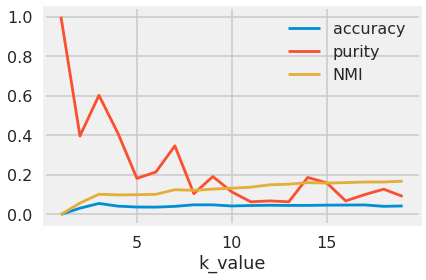

In [129]:
agg_results.plot(x='k_value')

In [212]:
agg_results.accuracy.max(), agg_results.purity.max()

(0.07795638107494643, 1.0)

In [132]:
kmeans_results=pd.DataFrame(columns=('iteration','accuracy','purity','NMI'))
for k in range(1,20):
    d2v_kmeans=clustering_fun(train_vect, cluster.KMeans, (), {'n_clusters':5})
    acc=metrics.adjusted_rand_score(d2v_kmeans, tra_lbl)
    purity=purity_score(d2v_kmeans,tra_lbl)
    nmi=metrics.normalized_mutual_info_score(d2v_kmeans,tra_lbl)
    print(acc,purity,nmi)
    lis_k=[int(k),acc,purity,nmi]
    kmeans_results.loc[k]=lis_k

(0.05062182504207512, 0.2237442922374429, 0.11018731569203263)
(0.04559998774420189, 0.1598173515981735, 0.10229056492283896)
(0.04873119828356977, 0.2009132420091324, 0.10523976078538326)
(0.04873119828356977, 0.1872146118721461, 0.10523976078538327)
(0.04873119828356977, 0.3470319634703196, 0.10523976078538326)
(0.05062182504207512, 0.1963470319634703, 0.11018731569203263)
(0.05062182504207512, 0.0684931506849315, 0.11018731569203263)
(0.05062182504207512, 0.1963470319634703, 0.11018731569203263)
(0.05062182504207512, 0.3424657534246575, 0.11018731569203263)
(0.05062182504207512, 0.3424657534246575, 0.11018731569203263)
(0.04587958896623406, 0.182648401826484, 0.10239156450615469)
(0.05062182504207512, 0.2237442922374429, 0.11018731569203263)
(0.05062182504207512, 0.1963470319634703, 0.11018731569203263)
(0.05062182504207512, 0.0684931506849315, 0.11018731569203262)
(0.04726580912993843, 0.1552511415525114, 0.10334525551900486)
(0.04873119828356977, 0.3470319634703196, 0.105239760785

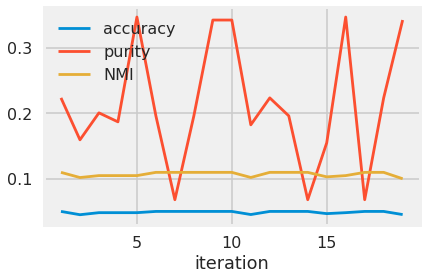

In [134]:
kmeans_results.plot(x='iteration')